[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/pinecone-import.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/docs/pinecone-import.ipynb)

# Import from object storage

**Note:** This feature is in [public preview](https://docs.pinecone.io/release-notes/feature-availability) and available only on [Standard and Enterprise plans](https://www.pinecone.io/pricing/).

## Scenario: Ingesting Parquet Data from S3 to Pinecone Serverless

In this scenario, we will be generating JSON data, embedding that data using the [Pinecone Inference API](https://docs.pinecone.io/guides/inference/understanding-inference), storing the data in AWS S3 as Parquet files, and ingesting the data from S3 into a Pinecone Serverless index.

### Problem Overview

The goal is to move the data from S3 to Pinecone so that it can be used for future tasks such as semantic search. This process ensures that the data is efficiently searchable and retrievable by applications.

### Solution Steps

1. **Generate data**: Begin by generating the data that needs to be processed.

2. **Chunk data**: Split the generated data into smaller, manageable chunks that can be processed and embedded effectively.

3. **Embed data**: Create vector embeddings from the chunked data. These embeddings are crucial for indexing and retrieval in Pinecone.

4. **Create Parquet files**: Save the vector embeddings, along with metadata, into Parquet files.

5. **Access S3 bucket**: Access the S3 bucket where the Parquet files will be stored.

6. **Upload Parquet files**: Upload the Parquet files containing the embeddings to the S3 bucket.

7. **Create Pinecone index**: Create a Pinecone index where the embeddings will be stored. This index will allow for efficient similarity search and other tasks.

8. **Load S3 data into Pinecone index**: Load the embeddings from the S3 bucket into the Pinecone index.


Please see our official [Understanding Imports in Pinecone documentation](https://docs.pinecone.io/guides/data/understanding-imports) for additional information.


The data flow for the notebook is outlined below:

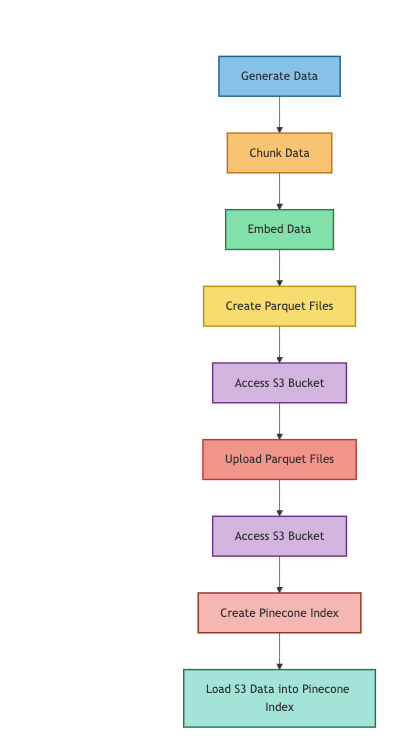

## Import required libraries

First, we need to import all the necessary libraries that will be used for phrase generation, text chunking, embedding, and uploading to S3.

In [ ]:
!pip install "pinecone~=8.0"
!pip install pinecone_notebooks
!pip install langchain
!pip install boto3

In [ ]:
import os
import random
from io import BytesIO

import boto3
import pandas as pd
from botocore.config import UNSIGNED, Config
from botocore.exceptions import ClientError
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pinecone import Pinecone, ServerlessSpec

## Generate unique phrases

In this step, we create a list of adjectives, nouns, and verbs, and then randomly combine them to form 100 unique phrases. Each phrase will follow the structure: 'The [adjective] [noun] [verb] over the [adjective] [noun]'. These phrases will be stored in a Pandas DataFrame for further processing.

In [ ]:
# Lists of words to combine into unique phrases
adjectives = [
    "quick",
    "lazy",
    "energetic",
    "bright",
    "dark",
    "mysterious",
    "bold",
    "silent",
    "wild",
    "brave",
]
nouns = [
    "fox",
    "dog",
    "cat",
    "tree",
    "river",
    "mountain",
    "bird",
    "sky",
    "lion",
    "tiger",
]
verbs = [
    "jumps",
    "runs",
    "flies",
    "sits",
    "sleeps",
    "roars",
    "whispers",
    "climbs",
    "chases",
    "observes",
]

# Generate 100 unique phrases
num_rows = 100
print(f"Generating {num_rows} unique phrases...")

# Create a DataFrame with unique phrases
data = [
    {
        "id": f"id{i}",
        "values": f"The {random.choice(adjectives)} {random.choice(nouns)} {random.choice(verbs)} over the {random.choice(adjectives)} {random.choice(nouns)}",
    }
    for i in range(num_rows)
]
df = pd.DataFrame(data)
print("Unique phrases generated.")
df.head()

Generating 100 unique phrases...
Unique phrases generated.


,id,values
0,id0,The brave tiger roars over the silent river
1,id1,The bold mountain observes over the mysterious...
2,id2,The bright tree roars over the quick bird
3,id3,The bold lion observes over the lazy river
4,id4,The mysterious bird climbs over the quick tree


## Chunk text using LangChain

Here we chunk the generated phrases into smaller pieces using LangChain's `RecursiveCharacterTextSplitter`. This is useful when working with large texts, as smaller chunks can be processed more efficiently.

In [ ]:
# Chunk the text column using LangChain's RecursiveCharacterTextSplitter
chunk_size = 1000
chunk_overlap = 100

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Perform the chunking process and store the chunked texts
chunked_texts = []

for text in df["values"]:
    if pd.isna(text) or text == "":
        chunked_texts.append([text])  # Keep empty texts as they are
    else:
        chunked_text = text_splitter.split_text(text)
        chunked_texts.append(chunked_text)

# Flatten the DataFrame by exploding the chunked texts into separate rows
df["values"] = chunked_texts
df_chunked = df.explode("values").reset_index(drop=True)
df_chunked.head()

,id,values
0,id0,The brave tiger roars over the silent river
1,id1,The bold mountain observes over the mysterious...
2,id2,The bright tree roars over the quick bird
3,id3,The bold lion observes over the lazy river
4,id4,The mysterious bird climbs over the quick tree


## Get your API key

In [ ]:
from pinecone_notebooks.colab import Authenticate

Authenticate()

## Initialize a Pinecone client

We load the Pinecone API key from a configuration file (`config.ini`) and initialize the Pinecone client. Pinecone will be used to embed the chunked text.

In [ ]:
api_key = os.getenv("PINECONE_API_KEY")

# Configure Pinecone client
pc = Pinecone(api_key=api_key)

## Embed text using the Pinecone Inference API

Next, we embed the chunked text using Pinecone's embedding model. We process each chunk and store the embedding values back into the DataFrame.

In [ ]:
# Function to get embeddings for a given text
def get_embedding(text):
    res = pc.inference.embed(
        model="multilingual-e5-large",
        inputs=text,
        parameters={
            "input_type": "query",  # or "passage"
            "truncate": "END",
        },
    )
    embedding = res.data[0]["values"]
    return embedding


# Embed the chunked phrases in the DataFrame
for index, row in df_chunked.iterrows():
    # print(f"Processing record {index + 1}/{len(df_chunked)}: {row['id']}")
    df_chunked.at[index, "values"] = get_embedding(row["values"])

print("All embeddings generated.")
df_chunked.head()

All embeddings generated.


,id,values
0,id0,"[-0.00984954833984375, 0.0060577392578125, -0...."
1,id1,"[0.0022792816162109375, 0.0202178955078125, -0..."
2,id2,"[0.0230560302734375, 0.02764892578125, -0.0150..."
3,id3,"[-0.01027679443359375, 0.0150299072265625, -0...."
4,id4,"[0.0034313201904296875, 0.016632080078125, -0...."


## Upload embedded data to S3

Now, we can upload the embedded DataFrame to an Amazon S3 bucket as Parquet files in chunks. This step uses the `boto3` library to interact with S3.

Be sure to replace the bucket name and folder name.

In [ ]:
# Function to convert the DataFrame to Parquet in-memory and upload to S3 in chunks
def upload_to_s3(df, bucket, folder, chunk_size=10):
    s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    total_rows = len(df)

    for i, start in enumerate(range(0, total_rows, chunk_size)):
        chunk = df.iloc[start : start + chunk_size]

        # Save the chunk as a Parquet file in memory
        parquet_buffer = BytesIO()
        chunk.to_parquet(parquet_buffer, index=False)
        parquet_buffer.seek(0)

        object_name = f"{folder}/part-{i}.parquet"
        try:
            # Upload the Parquet file from memory to S3
            s3_client.put_object(Body=parquet_buffer, Bucket=bucket, Key=object_name)
            print(f"Part-{i}.parquet successfully uploaded to {bucket}/{object_name}")
        except ClientError as e:
            print(f"Failed to upload part-{i}.parquet: {e}")


bucket_name = "rjbucketaws"  # Replace with your bucket name
folder_name = "1-1024-1/namespace1"  # Specify the folder name

# Start the upload process
upload_to_s3(df_chunked, bucket_name, folder_name)

## Create a serverless index




In [ ]:
# Get cloud and region settings
cloud = os.getenv("PINECONE_CLOUD", "aws")
region = os.getenv("PINECONE_REGION", "us-east-1")

# Define serverless specifications
spec = ServerlessSpec(cloud=cloud, region=region)

index_name = "pinecone-import1-1024-1"
dimension = 1024

# List all existing indexes
existing_indexes = pc.list_indexes()

# Check if the index exists
if index_name not in existing_indexes.names():
    # Create the index if it doesn't exist
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-west-2"),
    )
    print(f"Index '{index_name}' created successfully.")
else:
    print(f"Index '{index_name}' already exists.")

# Connect to the index
index = pc.Index(name=index_name)

In [ ]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Start import task

Each file contains:

*   **id**: Unique identifier
*   **Values**: Embedded vectors
*   **metadata**: JSON-formatted dictionary with metadata

***Note***: *This task may take 10 minutes or more to complete. Each import request can import up 1TB of data, or 100,000,000 records into a maximum of 100 namespaces, whichever limit is met first.*

## Specify AWS S3 folder and start task

In [ ]:
# Specify S3 data URI
root = "[YOUR S3 URI HERE]"

# Start import
op = index.start_import(uri=root, error_mode="ABORT")

## Check the status of the import

In [ ]:
index.describe_import(id=op.id)

## List import operations

In [ ]:
imports = list(index.list_imports())
if imports:
    for i in imports:
        print(i)
else:
    print("No imports found.")

## Describe a specific import

In [ ]:
index.describe_import("1")

## Cancel the Import (if needed)

In [ ]:
# Check if operation status and cancel running instance
op_status = index.describe_import(op.id)
print(f"Operation status: {op_status}")

if op_status in ["in_progress", "pending"]:
    try:
        cancel_response = index.cancel_import(op.id)
        print(f"Import operation {op.id} cancelled.")
    except Exception as e:
        print(f"Error cancelling import: {e}")
else:
    print(f"Cannot cancel operation {op.id} because its status is: {op_status}")

## Delete the index

In [ ]:
pc.delete_index(index_name)
print(f"Index '{index_name}' deleted.")

## Conclusion

In this notebook, we successfully generated random phrases, chunked them, embedded the chunked texts using Pinecone, and uploaded the final embedded data to Amazon S3. You can further customize this notebook for you use case by updating it to use your S3 bucket, changing the chunk size or embedding model as needed.